In [18]:
import numpy as np
import pylab as pl
from tqdm import tqdm
import res_utils as ru
import copy
import tensorflow as tf

In [19]:
# moduli parameters
moduli = [3, 5, 7]
n_mods = len(moduli)


# noise parameter
kappa = 0.1
var = 0.1

# initialize the result lists
all_est = []
error = []

# generate the random codebook vectors
codebooks = []

# resonator parameters
max_iters = 20
N = 2000  # hyper dimension
n = 784  # pattern dimesion


xvs = []
for m, mod in enumerate(moduli):
    codebooks.append(np.zeros((mod, N), dtype='complex'))
    xv = ru.cvecl(N, loopsize=mod)
    # [x1,x2,x3,]  for 3 moduli
    xvs.append(xv)
    for i in range(moduli[m]):
        codebooks[m][i, :] = xv**i

Mprod = np.prod(moduli)

In [20]:
# add in patterns to be stored here -- in this case, they're random and binary
S = np.random.choice([-1, 1], (n, Mprod))

In [21]:
# generate hook states for each residue pattern
H = np.ones((N, Mprod), dtype='complex')
for i in range(Mprod):
    for j in range(len(xvs)):
        H[:, i] *= xvs[j]**i

In [22]:
# demo for cleanup
resonator = np.zeros((n_mods, N), dtype='complex')
for i in range(n_mods):
    resonator[i, :] = np.random.normal(0.0, 1.0, size=(
        1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
    resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

idx = 31

# bit flip probability
p_flip = 0.1
print('Input state: ', idx)
vec = copy.copy(S[:, idx])

vec *= np.random.choice([-1, 1], n, p=[p_flip, 1-p_flip])  # print(vec)

print('Inner product with corrupted vector: ', np.vdot(S[:, idx], vec)/N)

res_input = H@np.linalg.pinv(S)@vec  # construct scaffold to hippocampus
n_iters, res_out = ru.gen_res_digit(resonator, codebooks, max_iters, res_input)

est = np.ones(N, dtype='complex')
for i in range(len(xvs)):
    est *= res_out[-1][i, :]

vec_hat = np.sign(S@np.linalg.pinv(H) @ est)
print('Inner product to correct solution: ', np.dot(S[:, idx], vec_hat)/N)

print('Closest state: ', np.argmax(np.linalg.pinv(H) @ est))

Input state:  31
Inner product with corrupted vector:  0.324
Inner product to correct solution:  (0.39199326720816097+0.0008608540541367809j)
Closest state:  31


In [23]:
n_trials = 10
p_flips = np.linspace(0, .5, 20)
accs = np.zeros((p_flips.size, n_trials))
sims = np.zeros((p_flips.size, n_trials))

for j in tqdm(range(p_flips.size)):
    for k in range(n_trials):

        resonator = np.zeros((n_mods, N), dtype='complex')
        for i in range(len(xvs)):
            resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
            resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

        idx = np.random.randint(Mprod)

        vec = copy.copy(S[:, idx])
        vec *= np.random.choice([-1, 1], n,
                                p=[p_flips[j], 1-p_flips[j]])  # print(vec)

        sims_noise = np.abs(np.dot(S[:, idx], vec)/N)

        res_input = H@np.linalg.pinv(S)@vec
        n_iters, res_out = ru.gen_res_digit(
            resonator, codebooks, max_iters, res_input)

        est = np.ones(N, dtype='complex')
        for i in range(len(xvs)):
            est *= res_out[-1][i, :]
        # print(n_iters)
        vec_hat = np.sign(
            S@np.linalg.pinv(H)@est)
        sims[j, k] = np.real(np.dot(S[:, idx], vec_hat)/N)
        if np.argmax(np.linalg.pinv(H)@est) == idx:
            accs[j, k] += 1

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


**Fashion MNIST**

In [24]:
# Load the FashionMNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


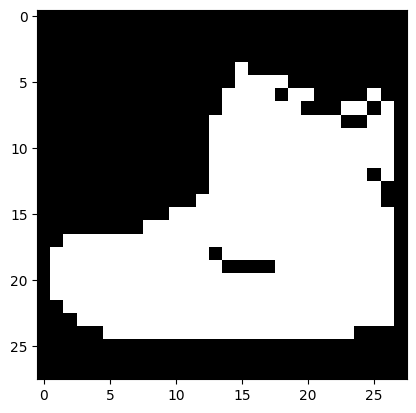

In [25]:
# binarize 105 images
images = np.zeros((105, 28, 28))
for i in range(105):
    images[i] = np.where(train_images[i] > 127, 1, -1)

pl.imshow(images[0], cmap='gray')

images = images.reshape(105, 28*28)
images = images.transpose()
images.shape
S = images

In [26]:
n_trials = 10
p_flips = np.linspace(0, .5, 20)

accs_fMNIST = np.zeros((p_flips.size, n_trials))
sims_fMNIST = np.zeros((p_flips.size, n_trials))

for j in tqdm(range(p_flips.size)):
    for k in range(n_trials):

        resonator = np.zeros((len(moduli), N), dtype='complex')
        num_iters = 20
        for i in range(3):
            resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
            resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

        idx = np.random.randint(Mprod)

        vec = copy.copy(S[:, idx])
        vec *= np.random.choice([-1, 1], 28*28,
                                p=[p_flips[j], 1-p_flips[j]])  # print(vec)

        res_input = H@np.linalg.pinv(S)@vec
        n_iters, res_out = ru.gen_res_digit(
            resonator, codebooks, num_iters, res_input)

        est = np.ones(N, dtype='complex')
        for i in range(len(res_out[-1][:, 0])):
            est *= res_out[-1][i, :]

        # print(n_iters)
        vec_hat = np.sign(
            S@np.linalg.pinv(H)@est)
        sims_fMNIST[j, k] = np.real(np.dot(S[:, idx], vec_hat)/N)
        if np.argmax(np.linalg.pinv(H)@est) == idx:
            accs_fMNIST[j, k] += 1

100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


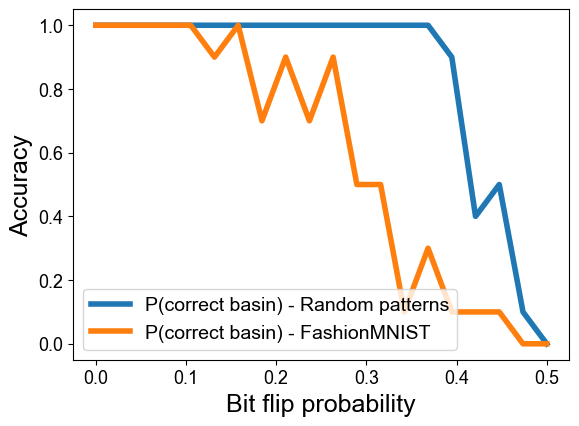

In [27]:
pl.rcParams['font.sans-serif'] = "Arial"
pl.rcParams['font.family'] = "sans-serif"

p_flips = np.linspace(0, 0.5, 20)
pl.plot(p_flips, np.mean(accs, axis=1),
        label='P(correct basin) - Random patterns', linewidth=4)
pl.plot(p_flips, np.mean(accs_fMNIST, axis=1),
        label='P(correct basin) - FashionMNIST', linewidth=4)
pl.legend(prop={'size': 14})
pl.xlabel('Bit flip probability', fontsize=18)
pl.ylabel('Accuracy', fontsize=18)
pl.tick_params(axis='both', which='major', labelsize=13)
pl.tick_params(axis='both', which='major', labelsize=13)
pl.subplots_adjust(bottom=0.15)

**Multiple patterns**

In [28]:
n=N

# add in patterns to be stored here -- in this case, they're random and binary
S = np.random.choice([-1, 1], (n, Mprod))

# generate hook states for each residue pattern
H = np.ones((N, Mprod), dtype='complex')
for i in range(Mprod):
    for j in range(len(xvs)):
        H[:, i] *= xvs[j]**i

In [29]:
n_trials = 10
p_flips = np.linspace(0, .5, 10)
n_patterns=[1,2]
#n_patterns=[1,2,3,4, 5,10]

all_acc=np.zeros((len(n_patterns),p_flips.size))
num_iters = 100

for ind_pat,n_pat in enumerate(n_patterns):
    accs = np.zeros(p_flips.size)
    for j in tqdm(range(p_flips.size)):
        p_flip = p_flips[j]
        for k in range(n_trials):

            resonator = np.zeros((n_mods, N), dtype='complex')
        
            for i in range(n_mods):
                resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                    1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
                resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

            indices = np.random.randint(Mprod, size=n_pat)
            indices = list(indices)
            vec = np.zeros(N)
            for i in range(n_pat):
                idx = indices[i]
                vec += copy.copy(S[:, idx])

            vec *= np.random.choice([-1, 1], N,
                                    p=[p_flips[j], 1-p_flips[j]])  # print(vec)

            for i in range(n_pat):
                res_input = H@np.linalg.pinv(S)@vec
                n_iters, res_out = ru.gen_res_digit(resonator, codebooks, num_iters, res_input)
                est=np.ones(N,dtype='complex')
                for i in range(len(xvs)):
                    est*=res_out[-1][i, :]
                vec_hat = np.sign(S@np.linalg.pinv(H) @ est)
                if np.argmax(np.linalg.pinv(H)@est) in indices:
                    accs[j] += 1
                    indices.remove(np.argmax(np.linalg.pinv(
                        H)@est))
                    vec = vec-np.real(vec_hat)
            all_acc[ind_pat,j]=accs[j]/n_pat

100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


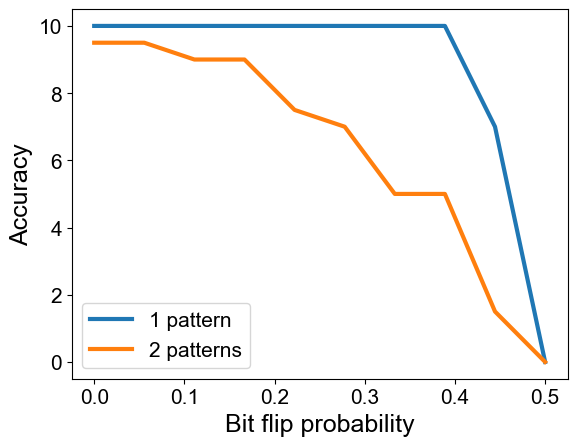

In [32]:
p_flips = np.linspace(0, 0.5, 10)

pl.plot(p_flips, all_acc[0], label='1 pattern', linewidth=3)

pl.plot(p_flips, all_acc[1], label='2 patterns', linewidth=3)



pl.legend(prop={'size': 15})
pl.xlabel('Bit flip probability', fontsize=18)
pl.ylabel('Accuracy', fontsize=18)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='major', labelsize=15)


# pl.savefig('figures/random_n_images.png')